# 8Hz Optogenetic Stimuation in Mouse LFP

A mouse implanted with a tetrode (hippocampus CA1) and an optogenetic stimulator (medial setpal area) recieves an 8Hz square wave pulse, entraining an 8Hz theta oscillation in the CA1 region. 

The 8Hz pulse was delivered with 3 different pulse widths: 37.5ms, 50ms, and 62.5ms (my mistake--an accident because I was trying to stimulate at 10Hz and 12Hz but misunderstood the software). 

Hypothesis: the entrained oscillation will change in shape, specifically peak-trough symmetry between the different pulse width conditions. In theory, the longer the pulse, the greater the assymmetry in theta waveform shape.

### Import needed python packages

In [72]:
import numpy as np
import pandas as pd
import scipy as sp
from fooof import FOOOF
import bycycle as byc
import neurodsp as ndsp

import neurodsp.filt as filt
import matplotlib.pyplot as plt

from bycycle.features import compute_features
from bycycle import burst

### Load data into pandas dataframe, get values as numpy array

In [63]:
# Path to data
path = './RodentOpto_LFP.txt'

# read data into pandas df
df = pd.read_csv(path, sep='\t')
df.columns = ['time_points', 'ch_1', 'ch_2', 'ch_3', 'ch_4']

# get channel 1 data as numpy array
data = df['ch_1'].values
stim = df['ch_4'].values

# sampling rate
fs= 2000

### Filter data at 50Hz to remove high frequency noise

In [64]:
datafilt = filt.filter_signal(data, fs=fs, pass_type='lowpass', f_range=50.0, remove_edges=False)

### Plot 6 seconds of data to visualize theta oscillation

Text(0.5, 0, 'Time (s)')

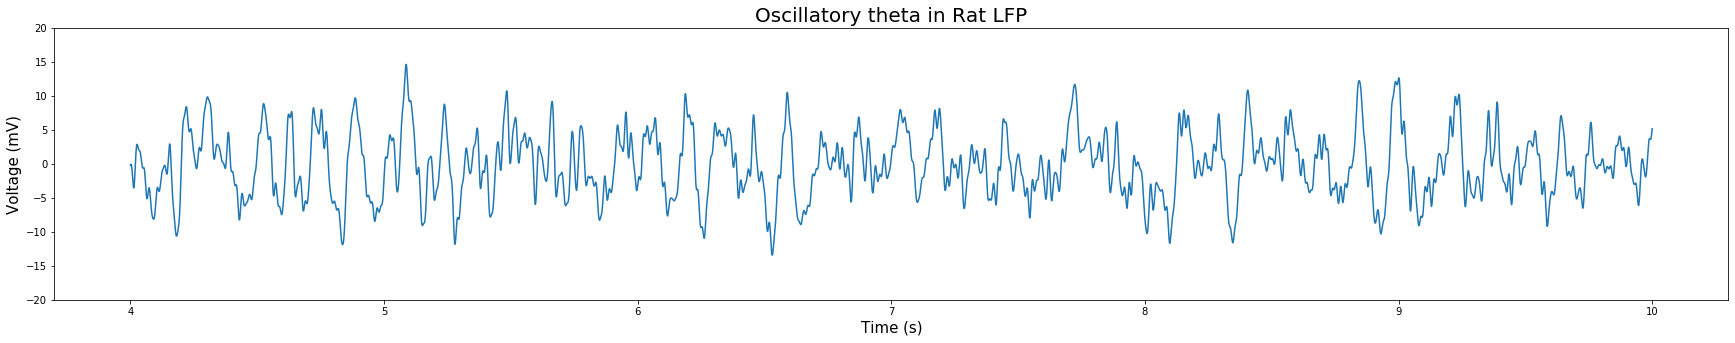

In [65]:
start = 4
end = 10

plt.figure(figsize=(30, 5))
plt.plot(df['time_points'].values[start*fs:end*fs], datafilt[start*fs:end*fs])
plt.ylim([-20,20])
plt.title('Oscillatory theta in Rat LFP', size=20)
plt.ylabel('Voltage (mV)', size=15)
plt.xlabel('Time (s)', size=15)

### Define Data Segments

Start and end of all periods of stimulation

In [66]:
start_0 = 1
end_0 = 39

start_50 = 39
end_50 = 102

start_62 = 118
end_62 = 217

start_37 = 325
end_37 = 393

### Make DFs for all data segments

In [67]:
# Set parameters for defining oscillatory bursts
osc_kwargs = {'amplitude_fraction_threshold': 0,
              'amplitude_consistency_threshold': .6,
              'period_consistency_threshold': .5,
              'monotonicity_threshold': .6,
              'N_cycles_min': 3}


f_theta = [6,10]

# Cycle-by-cycle analysis
df_0 = compute_features(datafilt[start_0*fs:end_0*fs], fs, f_theta, center_extrema='P',
                             burst_detection_kwargs=osc_kwargs)
df_50 = compute_features(datafilt[start_50*fs:end_50*fs], fs, f_theta, center_extrema='P',
                             burst_detection_kwargs=osc_kwargs)
df_37 = compute_features(datafilt[start_37*fs:end_37*fs], fs, f_theta, center_extrema='P',
                             burst_detection_kwargs=osc_kwargs)
df_62 = compute_features(datafilt[start_62*fs:end_62*fs], fs, f_theta, center_extrema='P',
                             burst_detection_kwargs=osc_kwargs)

### Limit analysis to only bursts

In [68]:
df_0_cycles = df_0[df_0['is_burst']][:100]
df_50_cycles = df_50[df_50['is_burst']][:200]
df_37_cycles = df_37[df_37['is_burst']][:200] #
df_62_cycles = df_62[df_62['is_burst']][:200] #368

### Plot Histograms with fit power density curves

Hide histograms--too visually noisy

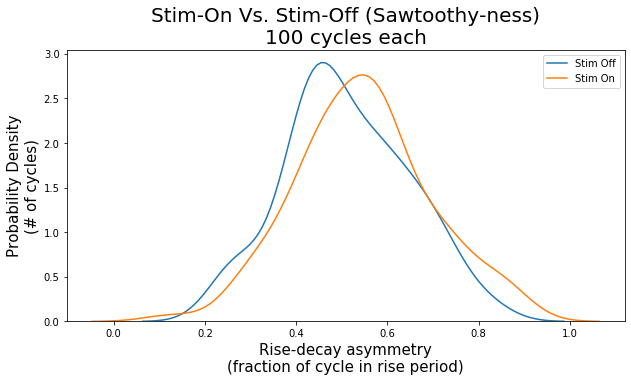

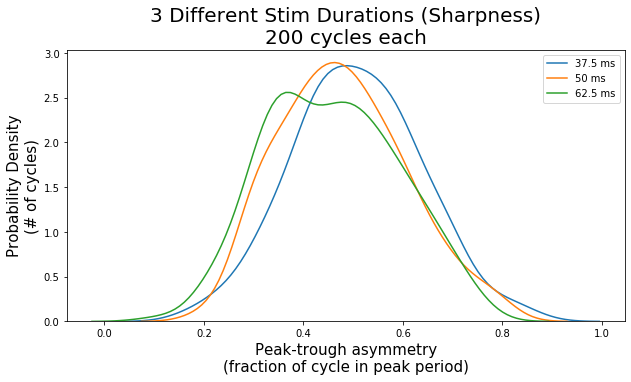

In [69]:
import seaborn as sns

plt.figure(figsize=[10,5])
sns.distplot(df_0_cycles['time_rdsym'], bins=10, hist=False, label='Stim Off')
sns.distplot(df_50_cycles['time_rdsym'][:100], bins=10, hist=False, label='Stim On')
plt.title('Stim-On Vs. Stim-Off (Sawtoothy-ness)\n100 cycles each', size=20)
plt.xlabel('Rise-decay asymmetry\n(fraction of cycle in rise period)', size=15)
plt.ylabel('Probability Density\n(# of cycles)', size=15)
plt.legend()

plt.figure(figsize=[10,5])
sns.distplot(df_37_cycles['time_ptsym'], bins=10, hist=False, label='37.5 ms')
sns.distplot(df_50_cycles['time_ptsym'], bins=10, hist=False, label='50 ms')
sns.distplot(df_62_cycles['time_ptsym'], bins=10, hist=False, label='62.5 ms')
plt.title('3 Different Stim Durations (Sharpness)\n200 cycles each', size=20)
plt.xlabel('Peak-trough asymmetry\n(fraction of cycle in peak period)', size=15)
plt.ylabel('Probability Density\n(# of cycles)', size=15)
plt.legend()

### FOOOF Spectrum

In [81]:
from neurodsp import spectral

output = spectral.compute_spectrum(data, fs, avg_type='median')

In [88]:
freqs = output[0]
spectrum = output[1]

In [84]:
fm = FOOOF()


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 50 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offs

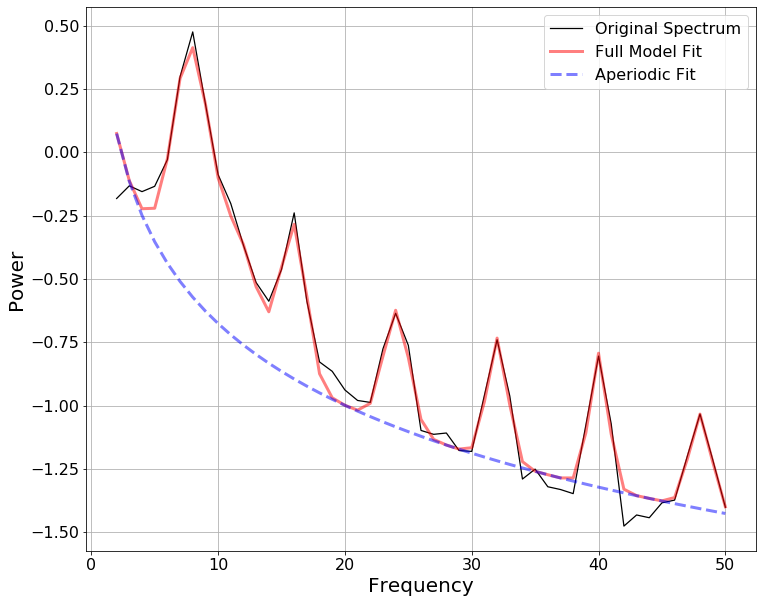

In [90]:
freq_range = [2,50]

fm.report(freqs, spectrum, freq_range)

Note: This is the spectrum for the entire channel 1 recording. overall, the spectrum resembles that of a sawtooth wave (power at all harmonics) -- interesting b/c much of the recording was during square wave stimulation